In [1]:
%matplotlib notebook

#Basic libraries
import pandas as pd
import numpy as np

#model algorithms
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier #this is not scikit's xgboost

#for plotting data
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt, matplotlib.image as mpimg
import seaborn as sns

#validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score

#pre-processing
from sklearn.preprocessing import Imputer

#add pipeline here
from sklearn.pipeline import make_pipeline

#keras
from keras.preprocessing import image
from keras.models import Sequential

import keras.layers as L
from keras.layers import Dense , Dropout, Lambda, Flatten, Activation
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam ,RMSprop
from keras.callbacks import EarlyStopping

#for os processes and shell commands 
from subprocess import check_output

/home/lazyowl/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/home/lazyowl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# general function to get_data
def get_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    return train, test

In [3]:
train_data, submission_data = get_data()

In [5]:
print(train_data.shape[0])

42000


In [24]:
num_rows, num_cols = 28, 28

x_train = train_data.ix[:, 1:].values.astype(np.float32)
x_train /= 255.0 
x_train = x_train.reshape(x_train.shape[0], 1, num_rows, num_cols)

# do similar thing with test data
x_test = submission_data.values.astype(np.float32)
x_test /= 255.0
x_test = x_test.reshape(x_test.shape[0], 1, num_rows, num_cols)

#get training label and convert to one-hot array
y_train = np_utils.to_categorical(train_data.ix[:,0])
num_classes = y_train.shape[1]

<IPython.core.display.Javascript object>


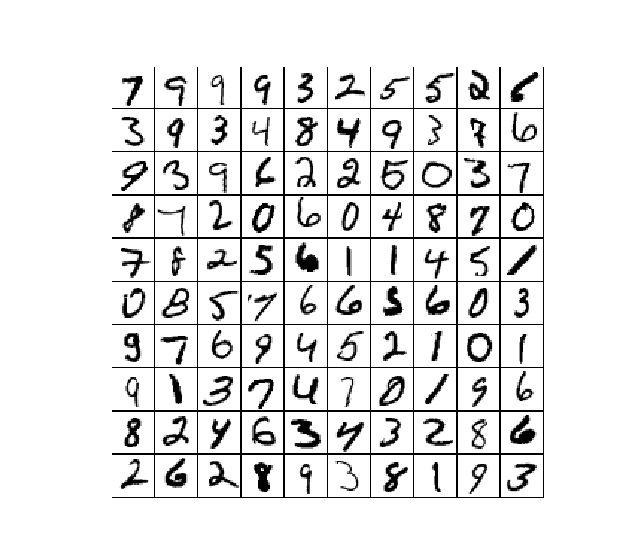

In [34]:
#helper function to visualize mnist training samples
def viz_mnist(data):
    
    n = int(np.ceil(np.sqrt(data.shape[0])))
    data = data.reshape((data.shape[0],data.shape[2], data.shape[3]))
    
    #add some padding between images 
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1)))
    
    data = np.pad(data, padding, mode='constant', constant_values=1)
    
    #reshape data into one big image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3))
    data = data.reshape((n * data.shape[1], n * data.shape[3]))
    
    plt.imshow(data, cmap='binary'); plt.axis('off')

#get some random index values of the training set   
idx = np.random.randint(0, train_data.shape[0], (100,))
data = x_train[idx,:,:,:]

#visualize the random samples
viz_mnist(data)

# Neural Network Architecture

In [27]:
# fix random seed for reproducibility
seed = 39
np.random.seed(seed)

In [28]:
### TUNEABLE PARAMETERS ###

# number of conv layer
nb_conv = 5
# list of numbers of filter for each conv layer (same number of values as nb_conv)
# size of pooling area for max pooling
pool_sz = 2

#size of batch per iteration
batch_size = 128
#number of epoches used for training
nb_epoch = 100

#number of dense layer (excluding softmax layer)
nb_dense = 1
nb_classes = 10             
#percentage of dropout for dense layer
drpt_rate = 0.25

In [59]:
##### CNN STRUCTURE #####

#Layer (type)                 Output Shape              Param #   
#=================================================================
#conv2d_53 (Conv2D)           (None, 64, 27, 27)        320       
#_________________________________________________________________
#activation_68 (Activation)   (None, 64, 27, 27)        0         
#_________________________________________________________________
#conv2d_54 (Conv2D)           (None, 64, 26, 26)        16448     
#_________________________________________________________________
#activation_69 (Activation)   (None, 64, 26, 26)        0         
#_________________________________________________________________
#conv2d_55 (Conv2D)           (None, 128, 24, 24)       73856     
#_________________________________________________________________
#activation_70 (Activation)   (None, 128, 24, 24)       0         
#_________________________________________________________________
#max_pooling2d_19 (MaxPooling (None, 128, 12, 12)       0         
#_________________________________________________________________
#conv2d_56 (Conv2D)           (None, 256, 10, 10)       295168    
#_________________________________________________________________
#activation_71 (Activation)   (None, 256, 10, 10)       0         
#_________________________________________________________________
#max_pooling2d_20 (MaxPooling (None, 256, 3, 3)         0         
#_________________________________________________________________
#flatten_13 (Flatten)         (None, 2304)              0         
#_________________________________________________________________
#dense_25 (Dense)             (None, 128)               295040    
#_________________________________________________________________
#activation_72 (Activation)   (None, 128)               0         
#_________________________________________________________________
#dropout_13 (Dropout)         (None, 128)               0         
#_________________________________________________________________
#dense_26 (Dense)             (None, 10)                1290      
#_________________________________________________________________
#activation_73 (Activation)   (None, 10)                0         
#=================================================================
#Total params: 682,122
#Trainable params: 682,122
#Non-trainable params: 0

In [64]:
model = Sequential()
#parameter: order no_filters, filter_row, filter_col
#filter_row and filter_col make up convolution kernel size
model.add(Convolution2D(64, (2, 2), border_mode='valid',
                        input_shape=(1, 28, 28), data_format = 'channels_first'))
model.add(Activation('relu'))

model.add(Convolution2D(64, (2, 2), data_format = 'channels_first'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))

model.add(Convolution2D(128, (3, 3), data_format = 'channels_first'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), data_format = 'channels_first'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 27, 27)        320       
_________________________________________________________________
activation_88 (Activation)   (None, 64, 27, 27)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 64, 26, 26)        16448     
_________________________________________________________________
activation_89 (Activation)   (None, 64, 26, 26)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 13, 13)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 128, 11, 11)       73856     
_________________________________________________________________
activation_90 (Activation)   (None, 128, 11, 11)       0         
__________

/home/lazyowl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), input_shape=(1, 28, 28..., data_format="channels_first", padding="valid")`


In [65]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=100, nb_epoch=50,
          verbose=1)

/home/lazyowl/anaconda3/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
42000/42000 [==============================] - 647s 15ms/step - loss: 0.4555 - acc: 0.8542
Epoch 2/50
42000/42000 [==============================] - 648s 15ms/step - loss: 0.1474 - acc: 0.9540
Epoch 3/50
42000/42000 [==============================] - 648s 15ms/step - loss: 0.1140 - acc: 0.9648
Epoch 4/50
42000/42000 [==============================] - 669s 16ms/step - loss: 0.0976 - acc: 0.9693
Epoch 5/50
42000/42000 [==============================] - 658s 16ms/step - loss: 0.0874 - acc: 0.9725
Epoch 6/50
42000/42000 [==============================] - 670s 16ms/step - loss: 0.0768 - acc: 0.9769
Epoch 7/50
42000/42000 [==============================] - 690s 16ms/step - loss: 0.0711 - acc: 0.9778
Epoch 8/50
42000/42000 [==============================] - 681s 16ms/step - loss: 0.0645 - acc: 0.9800
Epoch 9/50
42000/42000 [==============================] - 681s 16ms/step - loss: 0.0631 - acc: 0.9799
Epoch 10/50
42000/42000 [==============================] - 695s 17ms/step - loss: 

KeyboardInterrupt: 

In [66]:
y_pred = model.predict_classes(x_test)


In [68]:
print(y_pred.shape)


(28000,)


In [70]:
my_submission = pd.DataFrame({'Label': y_pred})
my_submission.index+=1

In [71]:
my_submission.to_csv('submission_CNN.csv', index=True,
                      header=True, index_label="ImageId")
submission_file = pd.read_csv('submission_CNN.csv')
print(submission_file)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      1
27983    2